In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy 
from sklearn.model_selection import ParameterGrid
from sklearn.manifold import Isomap
import time
from tqdm import tqdm

import librosa
from librosa import cqt
from librosa.core import amplitude_to_db
from librosa.display import specshow

import os
import glob
import h5py 

from utilities.isomapEmbedding import isomapEmbedding

In [2]:
hop_size= 512
q= 24

In [3]:
with h5py.File("TinySOL.h5", "r") as f:
    features_dict = {key:f[key][()] for key in f.keys()}

In [4]:
grid = {
    'Q': [24],
    'k': [3],
    'comp': ['log'],
    'instr': ['all'],
    'dyn': ['all']
}

settings = list(ParameterGrid(grid))

for setting in settings:
    
    if setting["instr"] == 'all':
        setting['instr'] = ''
    
    if setting['dyn'] == 'all':
        setting['dyn'] = ''

In [5]:
# Isomap embedding computation

batch_str = []

for setting in settings:
    
    q = setting['Q']
    # Batch process and store in a folder
    batch_str = [setting['instr'], setting['dyn']]

    batch_features = []
    for feature_key in features_dict.keys():
        # Get features that match setting
        
        if all(x in feature_key for x in batch_str):
            batch_features.append(features_dict[feature_key])
    
    batch_features = np.stack(batch_features, axis=1)
    print(batch_features.shape)
    
    isomap, freqs, rho_std = isomapEmbedding(batch_features)
    coords = isomap.embedding_

(168, 2913)


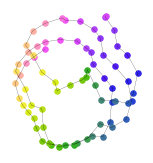

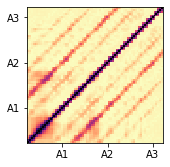

In [6]:
curr_fig= plt.figure(figsize=(5.5, 2.75))
ax= curr_fig.add_subplot(121)
ax.axis('off')

import colorcet as cc
subsampled_color_ids = np.floor(np.linspace(0, 256, q, endpoint=False)).astype('int')
color_list= [cc.cyclic_mygbm_30_95_c78[i] for i in subsampled_color_ids]

# Plot embedding with color
for i in range(coords.shape[0]):
    plt.scatter(coords[i, 0], coords[i, 1], color= color_list[i%q], s=30.0)

plt.plot(coords[:, 0], coords[:, 1], color='black', linewidth=0.2)

# Plot Pearson correlation matrix
rho_frequencies = freqs

freq_ticklabels = ['A1', 'A2', 'A3']
freq_ticks = librosa.core.note_to_hz(freq_ticklabels)

tick_bins = []
tick_labels= []
for i,freq_tick in enumerate(freq_ticks):
    tick_bin = np.argmin(np.abs(rho_frequencies-freq_tick))
    tick_bins.append(tick_bin)
    tick_labels.append(freq_ticklabels[i])

plt.figure(figsize=(2.5,2.5))
plt.imshow(np.abs(rho_std), cmap='magma_r')
plt.xticks(tick_bins)
plt.gca().set_xticklabels(freq_ticklabels)

plt.yticks(tick_bins)
plt.gca().set_yticklabels(freq_ticklabels)
plt.gca().invert_yaxis()

plt.clim(0, 1)


### Circle projection

In [7]:
from utilities.circle_fit import circle_fit

A = np.transpose(coords[:,:-1])
x, r, circle_residual = circle_fit(A)

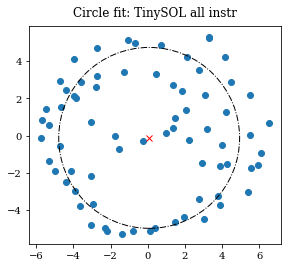

0.11785113019775813


In [8]:
matplotlib.rc('font', family='serif')

fig, axes = plt.subplots()
plt.scatter(A[0,:],A[1,:])
plt.plot(x[0],x[1],'rx')

circle = plt.Circle(x, radius=r, fill=False, linestyle='-.')

axes.set_aspect(1)
axes.add_artist(circle)

plt.title('Circle fit: TinySOL all instr', pad=10.0)
plt.show()

print(np.sqrt(circle_residual)/72)

In [9]:
import sympy

from sympy.geometry import Circle, Point, Line
from utilities.d_squared import d_squared

center = Point(x, evaluate=False)
c = Circle(center, r, evaluate=False)

l = Line(Point(coords[0,:-1]), center, evaluate=False)
points = [tuple(p) for p in l.points]

xy_prime = []

# TODO: Optimize to a more pythonic manner
for a,b in coords[:,:2]:
    
    intersections = c.intersection(Line(Point(a,b), center, evaluate=False))
    
    if d_squared((a,b),intersections[0]) < d_squared((a,b), intersections[1]):
        xy_prime.append([float(p) for p in intersections[0]])
    else:
        xy_prime.append([float(p) for p in intersections[1]])
        

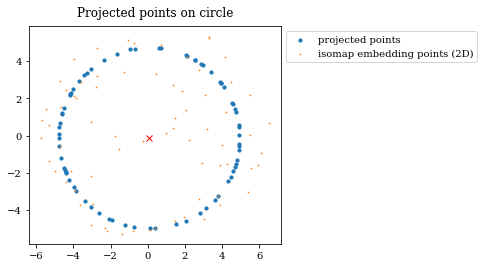

In [10]:
fig, axes = plt.subplots()
plt.scatter(np.array(xy_prime)[:,0],np.array(xy_prime)[:,1], s=10, 
            label='projected points')
plt.scatter(A[0,:],A[1,:], s=0.5, label='isomap embedding points (2D)')
plt.plot(center[0],center[1],'rx')

circle = plt.Circle([float(p) for p in center], radius=r, fill=False, 
                    linestyle='--', label='estimated circle fit')

axes.set_aspect(1)
# axes.add_artist(circle)

plt.title('Projected points on circle', pad=10.0)
plt.legend(bbox_to_anchor=(1,1))
plt.show()



In [30]:
vectors = coords[:,:-1] - x.T
azimuths = np.arctan2(vectors[:, 1], (1e-6 + vectors[:, 0]))
xy_new = np.asarray([x[0] + r * np.cos(azimuths), x[1] + r * np.sin(azimuths)]).T

min(xy_new[:,1])

-4.986045019041322

### Line projection

In [11]:
z = np.arange(len(coords[:,2]))
z_fit = scipy.stats.linregress(z, coords[:,2])
print(z_fit.stderr)

0.008383389057128201


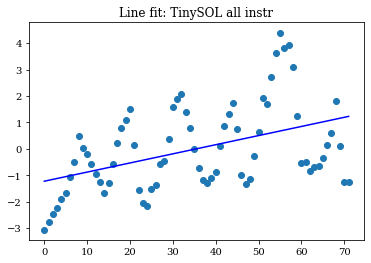

In [12]:
plt.figure()
plt.title('Line fit: TinySOL all instr')
plt.scatter(np.arange(len(coords[:,2])), coords[:,2])

plt.plot(z_fit.intercept + z_fit.slope*z, 'b')

In [13]:
# New line coordinates
z_prime = [i * z_fit.slope + z_fit.intercept for i,_ in enumerate(coords[:,2])]

In [14]:
coords_prime = np.append(np.array(xy_prime), np.expand_dims(np.array(z_prime), axis=1), axis=1)
coords_length = coords_prime.shape[0]

### Distance matrices 

In [15]:
from utilities.distance import self_distance

In [16]:
# Projected helix self-distance matrix
D_proj = self_distance(coords_prime)

# Isomap embedding self-distance matrix
D_isomap = self_distance(coords)

In [17]:
# Geodesic self-distance matrix
D_geodesic = isomap.dist_matrix_

# Convert to upper triangular sparse matrix
for i in range(coords_length):
    for j in range(i):
        D_geodesic[i,j] = 0

In [18]:
from utilities.matrix_operations import centered
from utilities.matrix_operations import frobenius_distance

In [20]:
loss_isomap = frobenius_distance(centered(D_geodesic), centered(D_isomap))/coords_length
loss_total = frobenius_distance(centered(D_geodesic), centered(D_proj))/coords_length
loss_proj = frobenius_distance(centered(D_isomap), centered(D_proj))/coords_length

In [21]:
print(f"Isomap loss= {loss_isomap}")
print(f"Projection loss= {loss_proj}")
print(f"Total loss= {loss_total}")

Isomap loss= 11.192415210749315
Projection loss= 5.263174367367614
Total loss= 11.78717458565251


In [22]:
(loss_total) - (loss_isomap + loss_proj) < 0

True